# TAGUP DATA ENGINEERING TAKE HOME CHALLENGE 
## By TzuHwan Seet

In [157]:
# import libraries
import pandas as pd
import sqlite3
from functools import reduce
import numpy as np
import xarray as xr
from scipy import stats

In [158]:
def read_feature_table_into_df(num_features=0, file_path="data/exampleco_db.db", static_data=False):
    """
    read feature tables from db and convert them into dataframes
    param num_features: number of feature tables to read
    param file_path: file path to db
    return: a list of dfs converted from tables
    """
    # create connection
    con = sqlite3.connect(file_path)
    if static_data:
        df = pd.read_sql_query(f"SELECT * FROM static_data", con)
        con.close()
        return df
    else:
        df_list = []
        for i in range(num_features):
            df = pd.read_sql_query(f"SELECT * FROM feat_{i}", con)
            df.name = f"feature_{i}"
            df_list.append(df)
        con.close()
        return df_list

dfs = read_feature_table_into_df(num_features=4)


In [159]:
dfs[0].head()

,timestamp,machine,value
0,2019-01-01 00:00:00.000000000,machine_0,12.626096
1,2019-01-01 08:00:09.603201067,machine_0,10.831994
2,2019-01-01 16:00:19.206402134,machine_0,21.083510
3,2019-01-02 00:00:28.809603201,machine_0,32.294495
4,2019-01-02 08:00:38.412804268,machine_0,28.057100


In [160]:
# Helper methods for data checking and cleaning
def check_number_of_machines(df):
    n = len(df.machine.unique())
    print(f"This table has {n} machines")

def check_null_values(df):
    assert df.isnull().sum().sum() == 0, "there are null values in df"
   
def check_column_types(df):
    assert df.dtypes["timestamp"] == "datetime64[ns]", "timestamp column is not datetime"
    assert df.dtypes["machine"] == "int64", "machine column is not int"
    assert df.dtypes[df.name] == "float64", "machine column is not float"
    
def convert_to_datetime(df):
    # check if column exists
    if "timestamp" not in df:
        raise ValueError("dataframe doesn't have timestamp column")
    df.timestamp = pd.to_datetime(df.timestamp, infer_datetime_format=True)

# remove "machine_" from machine column
def remove_machine_label(df):
    # check if column exists
    if "machine" not in df:
        raise ValueError("dataframe doesn't have machine column")
    df.machine = df.apply(lambda x: x.machine.split("_")[-1], axis=1)
    df.machine = pd.to_numeric(df.machine)

def rename_value_column(df):
    df.rename(columns={"value": df.name}, inplace=True)

# wrapper function for the tests
def clean_df(df_list):
    for df in df_list:
        print(f"~~~Checking dataframe of table {df.name}~~~")
        check_number_of_machines(df)
        check_null_values(df)
        convert_to_datetime(df)
        remove_machine_label(df)
        rename_value_column(df)
        check_column_types(df)




In [161]:
clean_df(dfs)

~~~Checking dataframe of table feature_0~~~
This table has 20 machines
~~~Checking dataframe of table feature_1~~~
This table has 20 machines
~~~Checking dataframe of table feature_2~~~
This table has 20 machines
~~~Checking dataframe of table feature_3~~~
This table has 20 machines


In [194]:
# Join all dfs 
combined_df = reduce(lambda left,right: pd.merge(left,right,on=["timestamp", "machine"]), dfs)

combined_df

,timestamp,machine,feature_0,feature_1,feature_2,feature_3
0,2019-01-01 00:00:00.000000000,0,12.626096,8.803120,-11.809200,10.083961
1,2019-01-01 08:00:09.603201067,0,10.831994,2.816327,11.554778,21.892853
2,2019-01-01 16:00:19.206402134,0,21.083510,-0.672645,-17.839178,-1.349024
3,2019-01-02 00:00:28.809603201,0,32.294495,6.525132,-13.498586,-4.250752
4,2019-01-02 08:00:38.412804268,0,28.057100,3.691359,21.984744,13.670561
...,...,...,...,...,...,...
59995,2021-09-25 15:59:21.587195728,19,0.002403,0.013519,0.002612,0.005599
59996,2021-09-25 23:59:31.190396800,19,0.023516,-0.004443,0.011515,0.009060
59997,2021-09-26 07:59:40.793597872,19,0.002002,-0.008331,-0.002329,-0.005856
59998,2021-09-26 15:59:50.396798944,19,-0.004232,-0.011988,-0.003764,-0.005268


## Removing Outliers 
- Visualizing the distribution of the 4 feature values for each machine suggests that the values are approximately normally distributed.
- With the normal distribution assumption I define an outlier as a value that is more than 3 standard deviations from the mean. However removing outlier rows would make reshaping the array into a shape suitable for ML pipeline challenging. 
- An alternative is to apply sklearn.robustScaler that removes the median and scales the data according the quantile range. 

### Results
*Removing outlier that is > 3 sd from mean*  



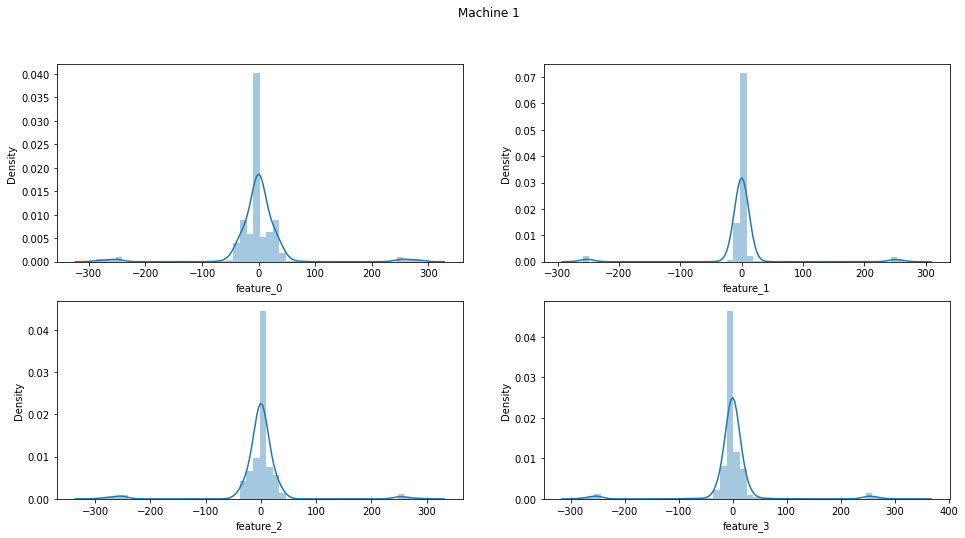

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

machine_no = 1
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.distplot(combined_df[combined_df.machine==machine_no]["feature_0"])
plt.subplot(2,2,2)
sns.distplot(combined_df[combined_df.machine==machine_no]["feature_1"])
plt.subplot(2,2,3)
sns.distplot(combined_df[combined_df.machine==machine_no]["feature_2"])
plt.subplot(2,2,4)
sns.distplot(combined_df[combined_df.machine==machine_no]["feature_3"])
plt.suptitle("Machine 1")
plt.show()

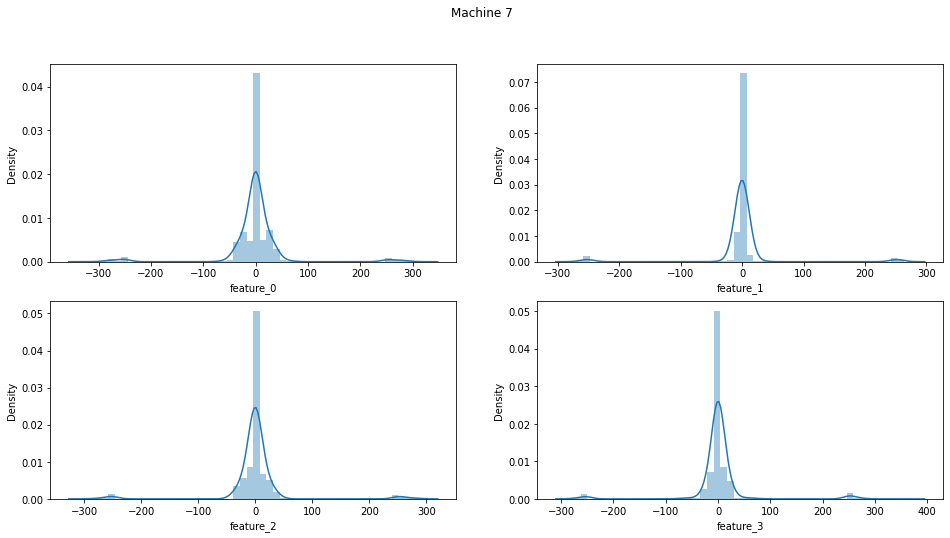

In [164]:
machine_no = 7
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.distplot(combined_df[combined_df.machine==machine_no]["feature_0"])
plt.subplot(2,2,2)
sns.distplot(combined_df[combined_df.machine==machine_no]["feature_1"])
plt.subplot(2,2,3)
sns.distplot(combined_df[combined_df.machine==machine_no]["feature_2"])
plt.subplot(2,2,4)
sns.distplot(combined_df[combined_df.machine==machine_no]["feature_3"])
plt.suptitle("Machine 7")
plt.show()

In [178]:
# remove the outlier rows associated with each 4 features for each machines 
filtered_df = pd.DataFrame()
for i in range(20):
    machine_df = combined_df[combined_df.machine==i]
    z_scores = stats.zscore(machine_df[["feature_0", "feature_1", "feature_2", "feature_3"]])
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    outlier_pct = (~filtered_entries).sum()/len(filtered_entries)
    machine_df = machine_df[filtered_entries]
    filtered_df = filtered_df.append(machine_df)

In [179]:
print("Before removing outliers")
print(combined_df[combined_df.machine==7].describe())
print("After removing outliers")
print(filtered_df[filtered_df.machine==7].describe())

Before removing outliers
       machine    feature_0    feature_1    feature_2    feature_3
count   3000.0  3000.000000  3000.000000  3000.000000  3000.000000
mean       7.0    -0.407498    -0.109949     0.300411     1.930839
std        0.0    61.010261    55.696517    57.535965    57.774384
min        7.0  -319.992744  -269.286952  -292.442903  -275.334298
25%        7.0    -0.461305    -0.242026    -1.152536    -0.029348
50%        7.0    -0.000344    -0.000184    -0.000248     0.000289
75%        7.0     1.192487     0.135678     0.350956     0.762235
max        7.0   310.721517   263.399610   285.202304   359.939478
After removing outliers
       machine    feature_0    feature_1    feature_2    feature_3
count   2462.0  2462.000000  2462.000000  2462.000000  2462.000000
mean       7.0    -0.058519     0.025819     0.034378     0.223546
std        0.0    18.265917     4.935374    13.025386    13.169668
min        7.0   -77.141126   -36.479024   -44.237782   -75.949506
25%        7.

In [214]:
# Alternative method that uses the median and the interquartile range 
from sklearn.preprocessing import RobustScaler

def apply_robust_scaler(series):
    transformer = RobustScaler().fit(series.values.reshape(-1,1))
    l = np.squeeze(transformer.transform(series.values.reshape(-1,1)))
    return l

for i in range(20):
    for j in range(4):
        l = apply_robust_scaler(combined_df[combined_df.machine==i][f"feature_{j}"])
        combined_df.loc[combined_df.machine==i, f"feature_{j}"] = l

combined_df[combined_df.machine==7].describe()




0       12.626096
1       10.831994
2       21.083510
3       32.294495
4       28.057100
          ...    
2995     0.004364
2996     0.004077
2997     0.007702
2998    -0.008149
2999     0.003465
Name: feature_0, Length: 3000, dtype: float64
3000
0        764.533280
1        655.900555
2       1276.628895
3       1955.452977
4       1698.879098
           ...     
2995       0.288536
2996       0.271187
2997       0.490678
2998      -0.469094
2999       0.234100
Name: feature_0, Length: 3000, dtype: float64
0       8.803120
1       2.816327
2      -0.672645
3       6.525132
4       3.691359
          ...   
2995   -0.010959
2996    0.000165
2997   -0.014708
2998    0.000107
2999    0.023451
Name: feature_1, Length: 3000, dtype: float64
3000
0       511.124764
1       163.524287
2       -39.049651
3       378.861991
4       214.329694
           ...    
2995     -0.631396
2996      0.014465
2997     -0.849034
2998      0.011107
2999      1.366479
Name: feature_1, Length: 3000, dtype: 

,machine,feature_0,feature_1,feature_2,feature_3
count,3000.0,3.000000e+03,3000.000000,3000.000000,3.000000e+03
mean,7.0,-2.461942e-01,-0.290611,0.199974,2.438847e+00
std,0.0,3.689113e+01,147.460796,38.268213,7.298586e+01
min,7.0,-1.934901e+02,-712.957345,-194.508911,-3.478277e+02
25%,7.0,-2.787300e-01,-0.640295,-0.766408,-3.744039e-02
50%,7.0,1.609363e-20,0.000000,0.000000,-3.388132e-20
75%,7.0,7.212700e-01,0.359705,0.233592,9.625596e-01
max,7.0,1.878845e+02,697.371134,189.693388,4.547080e+02


In [200]:
l = pd.Series(np.random.rand(5))
print(l)
transformer = RobustScaler().fit(l.values.reshape(-1,1))
p =transformer.transform(l.values.reshape(-1,1))
print(np.squeeze(p))


0    0.961436
1    0.446888
2    0.434433
3    0.020276
4    0.221519
dtype: float64
[ 2.3383933   0.05526495  0.         -1.83768194 -0.94473505]


In [202]:
combined_df[combined_df.machine==7].describe()

,machine,feature_0,feature_1,feature_2,feature_3
count,3000.0,3000.000000,3000.000000,3000.000000,3000.000000
mean,7.0,-0.407498,-0.109949,0.300411,1.930839
std,0.0,61.010261,55.696517,57.535965,57.774384
min,7.0,-319.992744,-269.286952,-292.442903,-275.334298
25%,7.0,-0.461305,-0.242026,-1.152536,-0.029348
50%,7.0,-0.000344,-0.000184,-0.000248,0.000289
75%,7.0,1.192487,0.135678,0.350956,0.762235
max,7.0,310.721517,263.399610,285.202304,359.939478


In [ ]:
print("Before robust Scalar")
print(combined_df[combined_df.machine==7].describe())
print("After robust Scalar")
print(filtered_df[filtered_df.machine==7].describe())

## Adding Static Data
To add the static data associated with each machine, I joined the static table and the filtered dataframe.

In [167]:
# Adding static data to combined_df
static_df = read_feature_table_into_df(static_data=True)

static_df.rename(columns={"machine_id": "machine"}, inplace=True)
# make sure that machine id matches
remove_machine_label(static_df)

static_df.head()


,machine,install_date,model,room
0,0,2019-01-01,Model A,Room 123
1,1,2019-01-01,Model A,Room 123
2,2,2019-01-01,Model A,Room 123
3,3,2019-01-01,Model A,Room 123
4,4,2019-01-01,Model A,Room 123


In [170]:
#join filtered_df and static_df
final_df = pd.merge(filtered_df,static_df,on=["machine"], how='left')

final_df.head()

,timestamp,machine,feature_0,feature_1,feature_2,feature_3,install_date,model,room
0,2019-01-01 00:00:00.000000000,0,12.626096,8.803120,-11.809200,10.083961,2019-01-01,Model A,Room 123
1,2019-01-01 08:00:09.603201067,0,10.831994,2.816327,11.554778,21.892853,2019-01-01,Model A,Room 123
2,2019-01-01 16:00:19.206402134,0,21.083510,-0.672645,-17.839178,-1.349024,2019-01-01,Model A,Room 123
3,2019-01-02 00:00:28.809603201,0,32.294495,6.525132,-13.498586,-4.250752,2019-01-01,Model A,Room 123
4,2019-01-02 08:00:38.412804268,0,28.057100,3.691359,21.984744,13.670561,2019-01-01,Model A,Room 123


In [171]:
final_df.shape

(49141, 9)

In [177]:
min = 10000
for i in range(20):
    l = len(final_df[final_df.machine==i].index)
    print(l)
    if l<min:
        min = l
print(min)

2458
2450
2458
2463
2466
2468
2459
2462
2450
2441
2450
2453
2466
2458
2453
2454
2462
2453
2463
2454
2441


In [172]:
final_df.values.reshape(20,-1,9).shape

ValueError: cannot reshape array of size 442269 into shape (20,newaxis,9)

In [25]:
# timestamp, install_date, model, room to be coordinate variables 
# feats are data variables, determined by timestamp

ds = xr.Dataset.from_dataframe(df_final)

In [81]:
# timestamp, install_date, model, room to be coordinate variables 
# feats are data variables, determined by timestamp
ds = xr.Dataset(
    data_vars={
        "feat_0": df_final.feature_0.values,
        "feat_1": df_final.feature_1.values,
        "feat_2": df_final.feature_2.values,
        "feat_0": df_final.feature_3.values,
    },
    coords={
        "timestamp": df_final.timestamp.values,
        "machine": df_final.machine.values,
        "install_date": df_final.install_date.values,
        "model": df_final.model.values,
        "rooom": df_final.room.values
    }
)

In [82]:
ds

<xarray.Dataset>
Dimensions:       (feat_0: 60000, feat_1: 60000, feat_2: 60000, timestamp: 60000, machine: 60000, install_date: 60000, model: 60000, rooom: 60000)
Coordinates:
  * feat_0        (feat_0) float64 10.08 21.89 -1.349 ... -0.005268 0.01233
  * feat_1        (feat_1) float64 8.803 2.816 -0.6726 ... -0.01199 0.006749
  * feat_2        (feat_2) float64 -11.81 11.55 -17.84 ... -0.003764 -250.0
  * timestamp     (timestamp) datetime64[ns] 2019-01-01 ... 2021-09-27
  * machine       (machine) int64 0 0 0 0 0 0 0 0 0 ... 19 19 19 19 19 19 19 19
  * install_date  (install_date) object '2019-01-01' ... '2019-01-01'
  * model         (model) object 'Model A' 'Model A' ... 'Model B' 'Model B'
  * rooom         (rooom) object 'Room 123' 'Room 123' ... 'Room 456' 'Room 456'
Data variables:
    *empty*

In [80]:
feat0 = df_final.feature_0.values.reshape(-1,3000)
feat1 = df_final.feature_1.values.reshape(-1,3000)
feat2 = df_final.feature_2.values.reshape(-1,3000)
feat3 = df_final.feature_3.values.reshape(-1,30000)


ds = xr.Dataset(
    {
        "feat_0": (["t", "m"],feat0),
        "feat_1": (["t", "m"],feat1),
        "feat_2": (["t", "m"],feat2),
        "feat_0": (["t", "m"],feat3),
    },
    # coords={
    #     "machine": (df_final.machine.unique()),
    #     "timestamp": (df_final.timestamp.unique()),
    # }
)

ValueError: conflicting sizes for dimension 't': length 20 on 'feat_1' and length 2 on {'t': 'feat_0', 'm': 'feat_0'}

In [56]:
# timestamp, install_date, model, room to be coordinate variables 
# feats are data variables 

feat0.shape

(20, 3000)

In [71]:
len(df_final.timestamp.unique())

3000

In [79]:
temp = 15 + 8 * np.random.randn(2, 1, 3)

precip = 10 * np.random.rand(2, 1, 3)

lon = [-99.83, -99.23]

lat = [42.21, 42.59]

ds = xr.Dataset(
    {
           "temperature": (["lon", "lat", "time"], temp),
            "precipitation": (["lon", "lat", "time"], precip),
        },
        coords={
            "lon": (lon),
            "lat": (lat),
            "time": pd.date_range("2014-09-06", periods=3),
            "reference_time": pd.Timestamp("2014-09-05"),
        },
    )

ds

ValueError: conflicting sizes for dimension 'lat': length 2 on 'lat' and length 1 on {'lon': 'temperature', 'lat': 'temperature', 'time': 'temperature'}